# Introduction
Недавно образовалась компания MLaaS, которая предоставляет платные услуги через Интернет. Компания растет, ей понадобилось улучшить инфраструктуру для обслуживания запросов. Сотрудники не хотят выделять *слишком* много ресурсов, поскольку это дорого обойдется. С другой стороны, надо зарезервировать *достаточное* число ресурсов, иначе есть риск не обработать все запросы и потерять прибыль. Коротко говоря, хотелось бы заранее знать, когда запросить дополнительные серверы в облаке, чтобы обслужить все поступающие запросы, при этом не платить за неиспользованные ресурсы

**Вопрос:** когда мы достигнем предельной пропускной способности инфраструктуры (100 000 запросов в час)?

# libraries

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')
sns.set_style('darkgrid')

In [50]:
def visualize_model_line(X, y, estimators=None, legends=None):
    plt.figure(figsize=(14, 8))
    plt.scatter(X, y, s=10)
    if estimators:
        for i, estimator in enumerate(estimators):
            plt.plot(X, estimator(X), 'g-', linewidth=4)
            plt.legend([legends[i]], loc='upper left')
    plt.title('Web-traffic over last motnh', fontdict={'fontsize':25})
    plt.ylabel('Hints/hour', fontdict={'fontsize':25})
    plt.xlabel('Time', fontdict={'fontsize':25})
    plt.xticks([w*7*24 for w in range(10)], ['week %i' % w for w in range(10)])
    plt.tick_params(axis='x', labelsize=20)
    plt.autoscale()
    plt.show()

# Data loading
Данные представляют собой статистику веб за последний месяц: количество запросов в час (1 столбец соответствует *часу*, 2 - *числу запросов*)

In [43]:
data = np.genfromtxt('data/web_traffic.tsv', delimiter='\t')
print('Размер имеющихся данных:', data.shape)
data[:10]

Размер имеющихся данных: (743, 2)


array([[1.000e+00, 2.272e+03],
       [2.000e+00,       nan],
       [3.000e+00, 1.386e+03],
       [4.000e+00, 1.365e+03],
       [5.000e+00, 1.488e+03],
       [6.000e+00, 1.337e+03],
       [7.000e+00, 1.883e+03],
       [8.000e+00, 2.283e+03],
       [9.000e+00, 1.335e+03],
       [1.000e+01, 1.025e+03]])

# Data cleaning

In [44]:
X, y = data[:, 0], data[:, 1]
print('Чило пропущенных значений:', np.sum(np.isnan(y)))

Чило пропущенных значений: 8


In [45]:
# avoid nan objects
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]

# Visual analysis

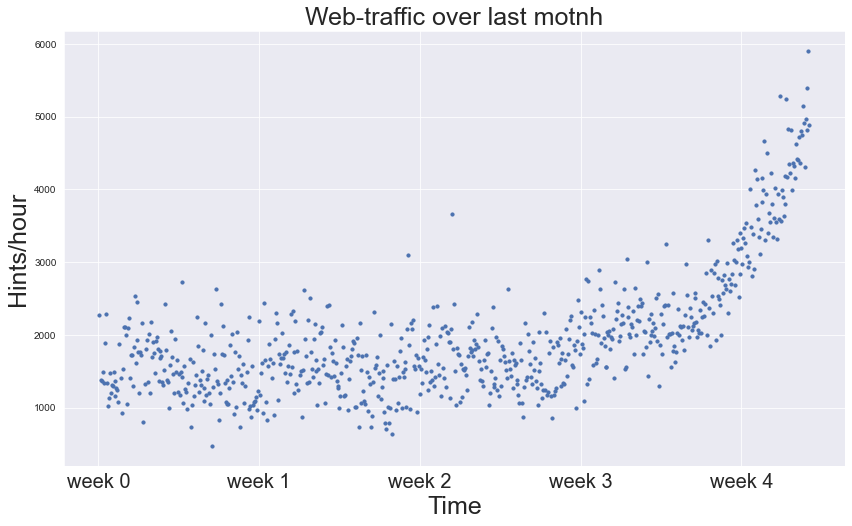

In [46]:
visualize_model_line(X, y)

Из графика видно, что в последнюю неделю наблюдался стабильный рост количества запросов в час

# Building ML model
Нам необходимо ответить на вопрос: *как долго сервер сможет обслуживать входящий трафик?*

Модель машинного обучения должны экстраполировать данные на будущее и предсказать, в какой момент трафик превысит границу допустимого (то есть предсказать момент (час), в который потребуется расширять инфраструктуру).

### Simple 1d linear estimator
Начнем с простой прямой, для которой погрешность аппроксимации минимальна

In [47]:
fp1, residuals, rank, sv, rcond = np.polyfit(X, y, 1, full=True)
print('Параметры линейной модели: ', fp1)
print('Погрешность аппроксимации: ', residuals)
print(rank, sv, rcond)

Параметры линейной модели:  [  2.59619213 989.02487106]
Погрешность аппроксимации:  [3.17389767e+08]
2 [1.36699071 0.36240365] 1.63202784619898e-13


In [48]:
# конструируем модель
estimator_1d = np.poly1d(fp1)
print('Ошибка аппроксимации: ', np.sum((estimator_1d(X)-y)**2))

Ошибка аппроксимации:  317389767.33977807


Сама по себе ошибка апроксимации мало о чем говорит (потому что сильно влияет масштаб и диапазоны самих данных), но при сравнении различных моделей эта метрика может быть полезна

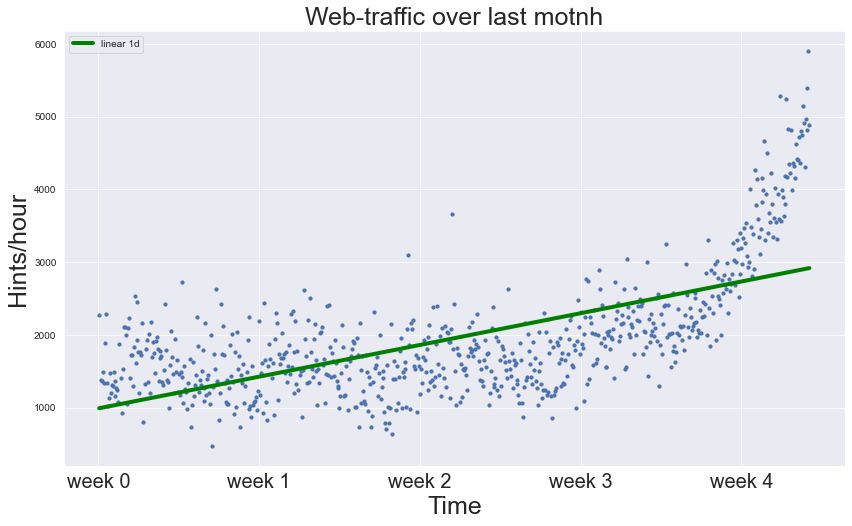

In [51]:
# визуализируем
visualize_model_line(X, y, [estimator_1d], ['linear 1d'])

### 2d polynom estimator


In [52]:
f2p, residuals, _, _, _ = np.polyfit(X, y, 2, full=True)
estimator_2d = np.poly1d(f2p)
print('Ошибка аппроксимации:', residuals)

Ошибка аппроксимации: [1.79983508e+08]


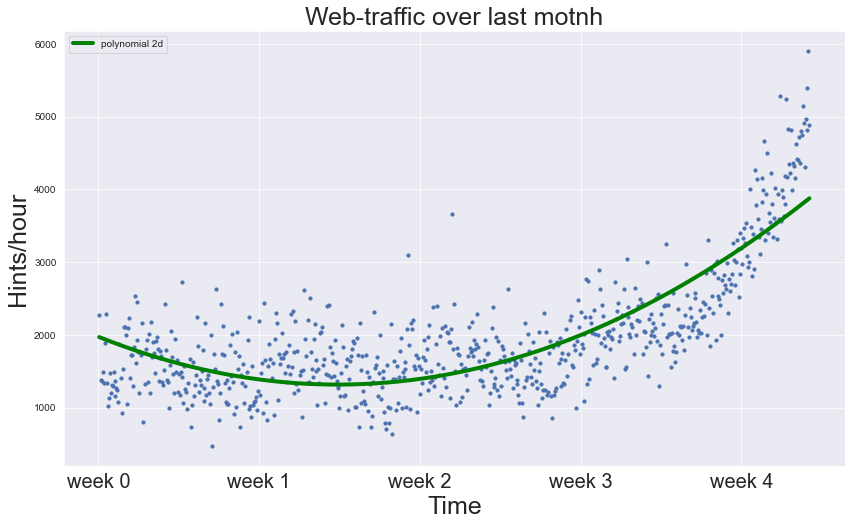

In [53]:
visualize_model_line(X, y, [estimator_2d], ['polynomial 2d'])

Модель значительно улучшила результаты, но величина ошибки по-прежнему высокая, следовательно, необходимо делать поправки. Известно, что полиномы высокой степени могут привести к переобучению. С другой стороны, однофакторная линейная модель слишком проста. **Следствие:** надо получше узнать природу данных и рассмотреть другие варианты экстраполяции.

Заметим, что график содержит точку изгиба примерно на 3.5 неделе. До этого момента число запросов составляет около 1000-2300 запросов в час. Рост наблюдается с 3 по 4 неделю. Разделим данные на 2 части и будет аппроксимировать каждую из них по отдельности

In [63]:
point_inflection = int(3.5 * 7 * 24)
X1, y1 = X[:point_inflection], y[:point_inflection]
X2, y2 = X[point_inflection:], y[point_inflection:]
estimator_for_1part = np.poly1d(np.polyfit(X1, y1, 1))
estimator_for_2part = np.poly1d(np.polyfit(X2, y2, 2))
error_1part = np.sum((estimator_for_1part(X1)-y1)**2)
error_2part = np.sum((estimator_for_2part(X2)-y2)**2)
print('Ошибка на первом этапе:', error_1part)
print('Ошибка на втором этапе:', error_2part)
print('Суммарная ошибка аппроксимации:', error_1part+error_2part)

Ошибка на первом этапе: 110806407.08999814
Ошибка на втором этапе: 19768846.989176333
Суммарная ошибка аппроксимации: 130575254.07917447


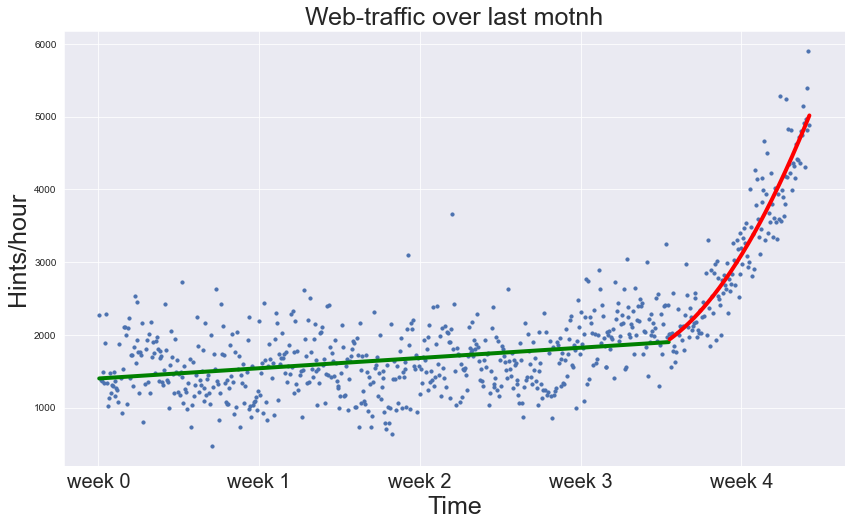

In [62]:
plt.figure(figsize=(14, 8))
plt.scatter(X, y, s=10)
plt.plot(X1, estimator_for_1part(X1), 'g-', linewidth=4)
plt.plot(X2, estimator_for_2part(X2), 'r-', linewidth=4)
plt.title('Web-traffic over last motnh', fontdict={'fontsize':25})
plt.ylabel('Hints/hour', fontdict={'fontsize':25})
plt.xlabel('Time', fontdict={'fontsize':25})
plt.xticks([w*7*24 for w in range(10)], ['week %i' % w for w in range(10)])
plt.tick_params(axis='x', labelsize=20)
plt.autoscale()
plt.show()

Результат значительно исправился, однако мы все еще не можем утверждать, что это лучшее, что мы можем "выжать" из данных.

# Answering
Теперь можем ответить на вопрос, когда число запросов достигнет 100 000 запросов / час. Для этого нужно решить квадратное уравнение

In [71]:
# x0 - начальная позиция, берем 750 (у нас всего 743 точки)
answering = sp.optimize.fsolve(estimator_for_2part-100000, x0=750)
print(f'На {round((answering / (24 * 7)).item(), 2)} неделе потребуется закупка новой инфраструктуры') 

На 9.84 неделе потребуется закупка новой инфраструктуры


Конечно, полученный результат не вполне достоверен. Можно собрать больше данных и попытаться сделать лучший прогноз, но полностью точную модель построить не удастся. Полученный прогноз дает возможность заранее предпринять некоторые действия, поэтому исследование оказалось полезным.